## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import time

### Data quality check
*By Lilly Sorkin*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [140]:
continuous = []
for col in movie_industry.columns:
    if movie_industry.dtypes[col] != object:
        continuous.append(col)
continuous.remove('gross')
continuous        

['year', 'score', 'votes', 'budget', 'runtime']

Text(0, 0.5, 'Count')

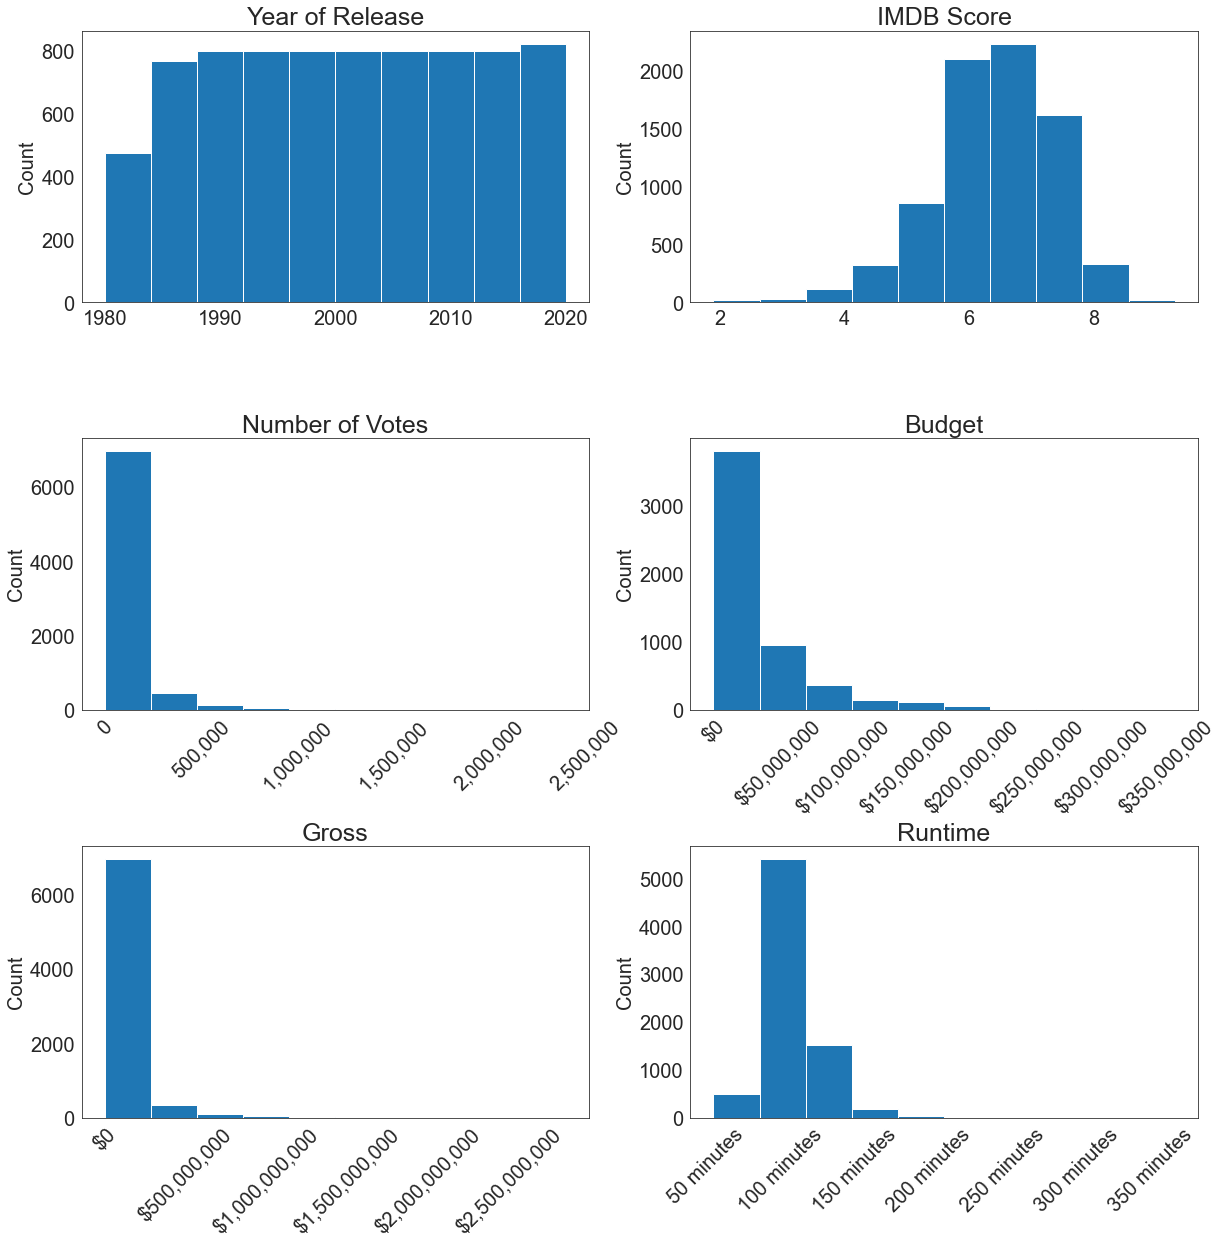

In [93]:
sns.set_style('white')
fig, axes = plt.subplots(3,2,figsize=(20,20))
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.5)

axes[0,0].hist(movie_industry.year)
axes[0,0].set_title('Year of Release', fontsize=25)
axes[0,0].tick_params(axis = 'both',labelsize=20)
axes[0,0].set_ylabel('Count', fontsize=20)

axes[0,1].hist(movie_industry.score)
axes[0,1].set_title('IMDB Score', fontsize=25)
axes[0,1].tick_params(axis = 'both',labelsize=20)
axes[0,1].set_ylabel('Count', fontsize=20)

axes[1,0].hist(movie_industry.votes)
axes[1,0].set_title('Number of Votes', fontsize=25)
axes[1,0].tick_params(axis = 'both',labelsize=20)
axes[1,0].xaxis.set_major_formatter('{x:,.0f}')
axes[1,0].tick_params(axis='x', labelrotation=45)
axes[1,0].set_ylabel('Count', fontsize=20)

axes[1,1].hist(movie_industry.budget)
axes[1,1].set_title('Budget', fontsize=25)
axes[1,1].tick_params(axis = 'both',labelsize=20)
axes[1,1].xaxis.set_major_formatter('${x:,.0f}')
axes[1,1].tick_params(axis='x', labelrotation=45)
axes[1,1].set_ylabel('Count', fontsize=20)

axes[2,0].hist(movie_industry.gross)
axes[2,0].set_title('Gross', fontsize=25)
axes[2,0].tick_params(axis = 'both',labelsize=20)
axes[2,0].xaxis.set_major_formatter('${x:,.0f}')
axes[2,0].tick_params(axis='x', labelrotation=45)
axes[2,0].set_ylabel('Count', fontsize=20)


axes[2,1].hist(movie_industry.runtime)
axes[2,1].set_title('Runtime', fontsize=25)
axes[2,1].tick_params(axis = 'both',labelsize=20)
axes[2,1].xaxis.set_major_formatter('{x:.0f} minutes')
axes[2,1].tick_params(axis='x', labelrotation=45)
axes[2,1].set_ylabel('Count', fontsize=20)

In [139]:
categorical = []
for col in movie_industry.columns:
    if movie_industry.dtypes[col] == object:
        categorical.append(col)
categorical.remove('name')
categorical        

['rating',
 'genre',
 'released',
 'director',
 'writer',
 'star',
 'country',
 'company']

Text(0, 0.5, 'Count')

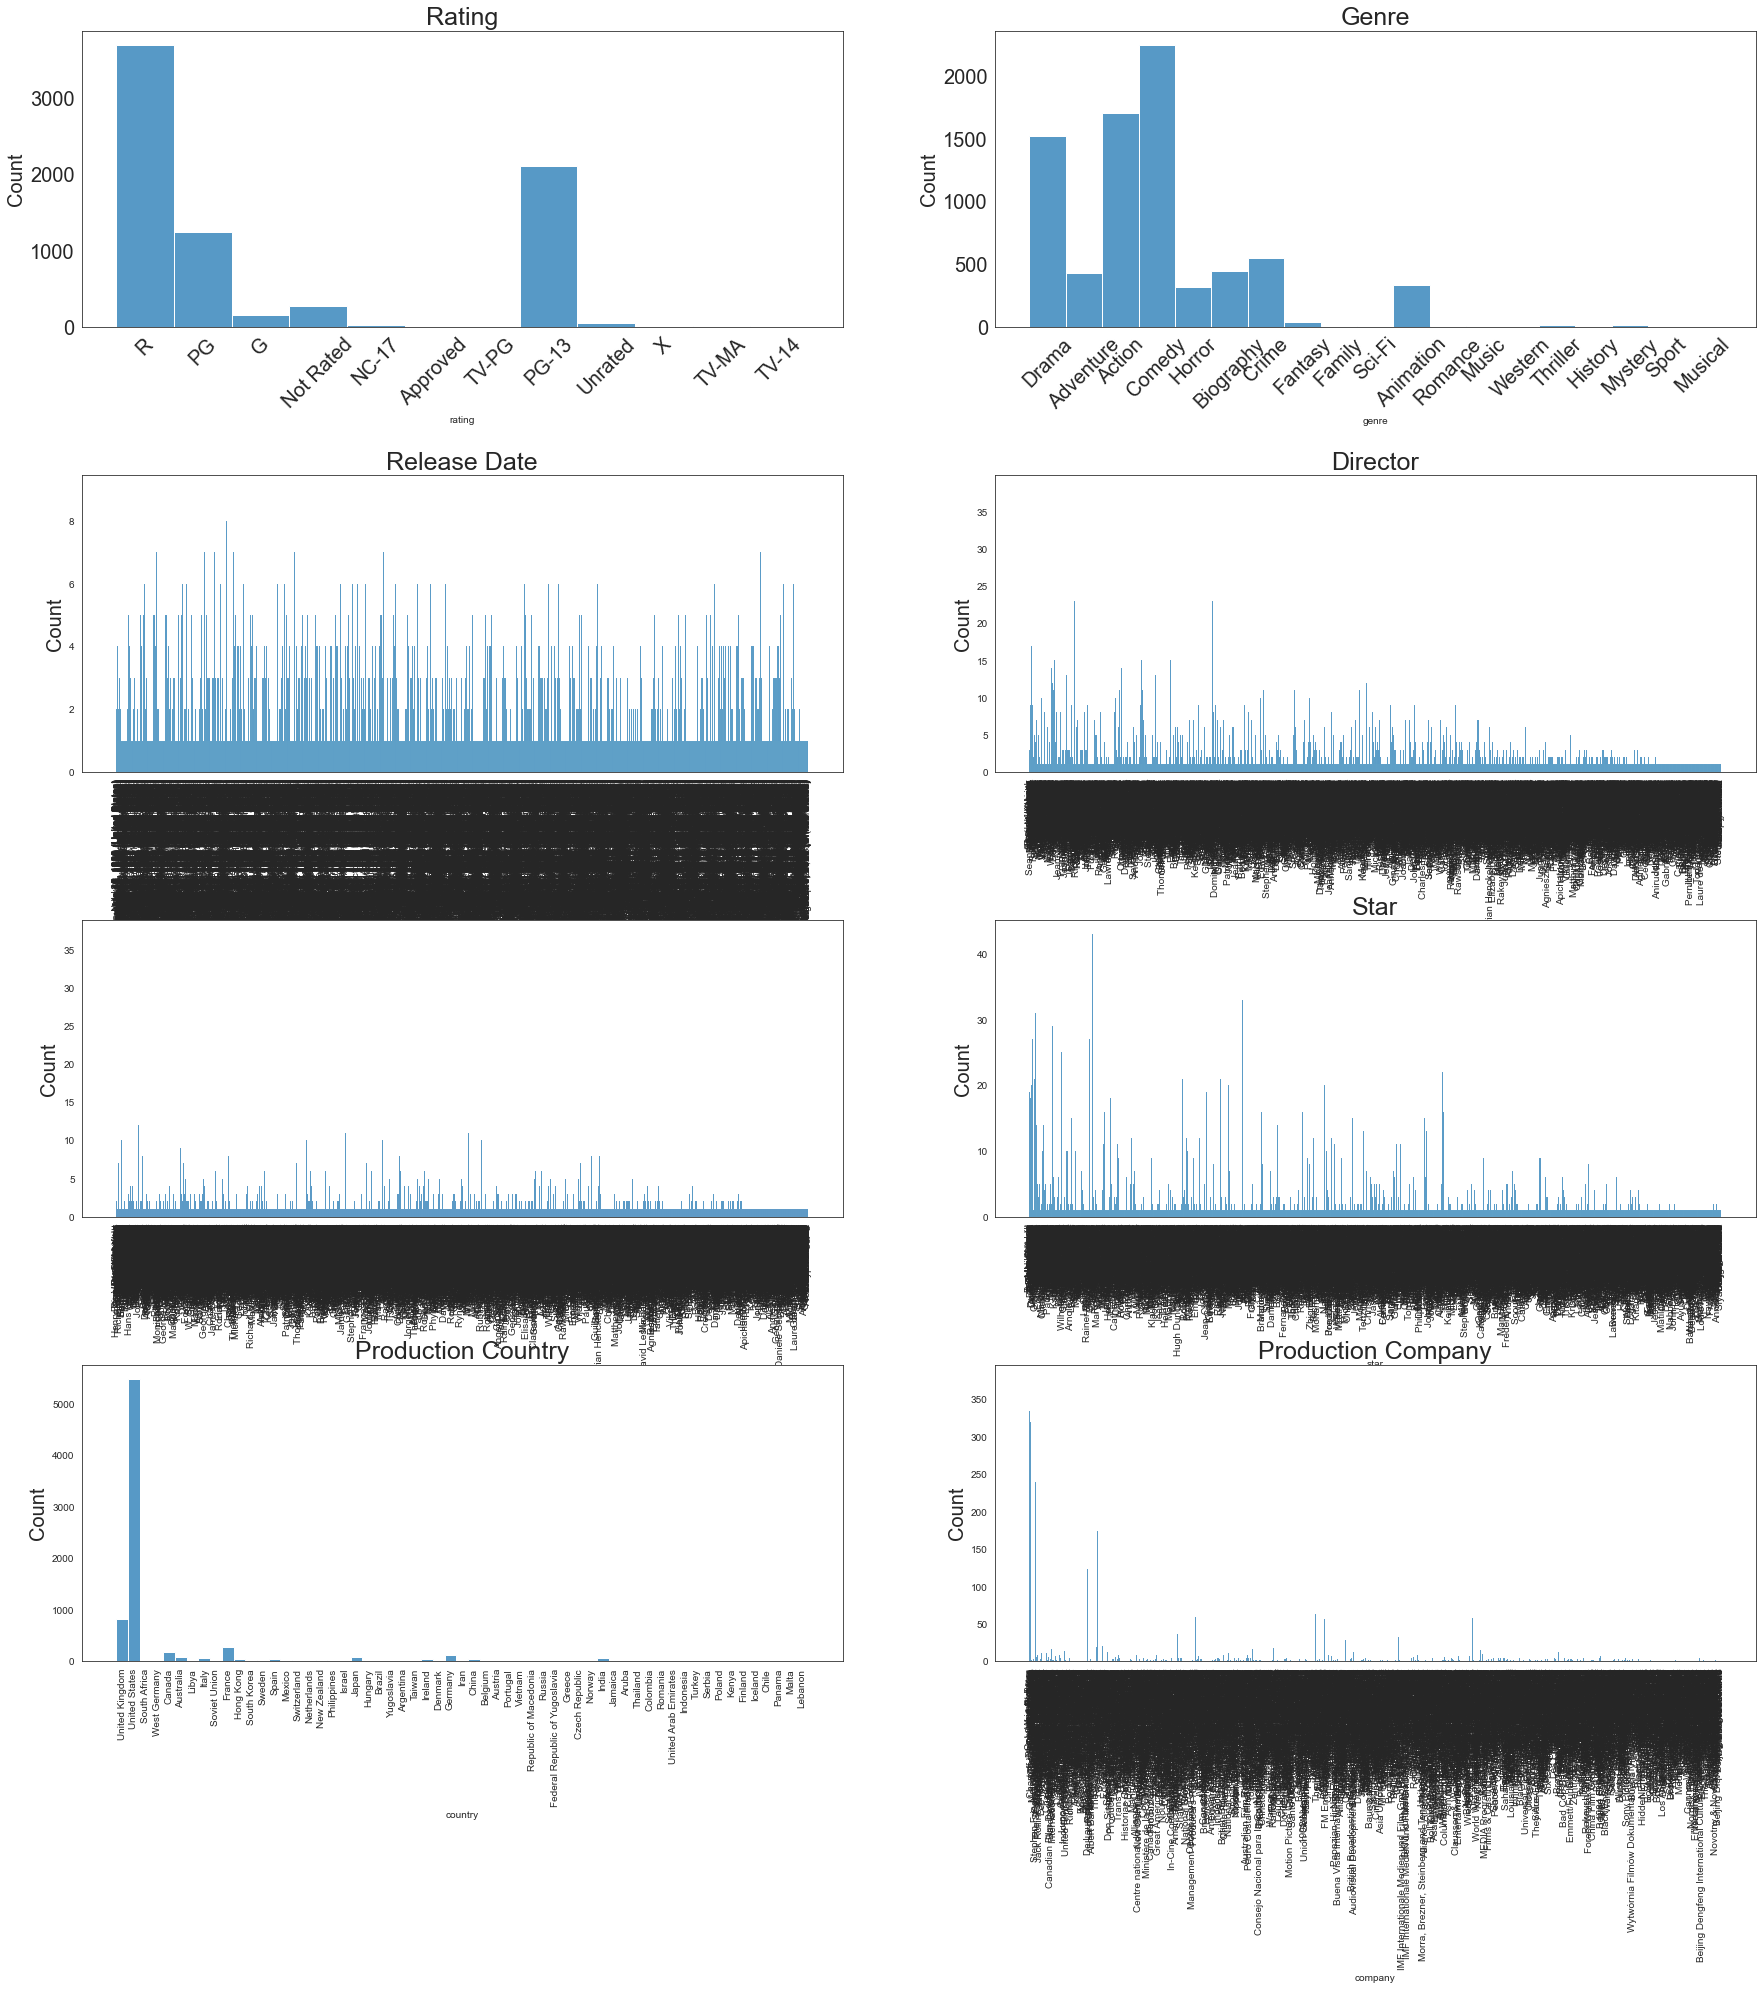

In [142]:
sns.set_style('white')
fig, axes = plt.subplots(4,2,figsize=(30,30))
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.5)

sns.histplot(ax=axes[0,0],x='rating', data = movie_industry)
axes[0,0].set_title('Rating', fontsize=25)
axes[0,0].tick_params(axis = 'both',labelsize=20)
axes[0,0].tick_params(axis='x', labelrotation=45)
axes[0,0].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[0,1], x='genre', data = movie_industry)
axes[0,1].set_title('Genre', fontsize=25)
axes[0,1].tick_params(axis = 'both',labelsize=20)
axes[0,1].tick_params(axis='x', labelrotation=45)
axes[0,1].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[1,0], x='released', data = movie_industry)
axes[1,0].set_title('Release Date', fontsize=25)
axes[1,0].tick_params(axis = 'both',labelsize=10)
axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,0].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[1,1], x='director', data = movie_industry)
axes[1,1].set_title('Director', fontsize=25)
axes[1,1].tick_params(axis = 'both',labelsize=10)
axes[1,1].tick_params(axis='x', labelrotation=90)
axes[1,1].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[2,0], x='writer', data = movie_industry)
axes[2,0].set_title('Writer', fontsize=25)
axes[2,0].tick_params(axis = 'both',labelsize=10)
axes[2,0].tick_params(axis='x', labelrotation=90)
axes[2,0].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[2,1], x='star', data = movie_industry)
axes[2,1].set_title('Star', fontsize=25)
axes[2,1].tick_params(axis = 'both',labelsize=10)
axes[2,1].tick_params(axis='x', labelrotation=90)
axes[2,1].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[3,0], x='country', data = movie_industry)
axes[3,0].set_title('Production Country', fontsize=25)
axes[3,0].tick_params(axis = 'both',labelsize=10)
axes[3,0].tick_params(axis='x', labelrotation=90)
axes[3,0].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[3,1], x='company', data = movie_industry)
axes[3,1].set_title('Production Company', fontsize=25)
axes[3,1].tick_params(axis = 'both',labelsize=10)
axes[3,1].tick_params(axis='x', labelrotation=90)
axes[3,1].set_ylabel('Count', fontsize=20)

In [106]:
predictors = list(movie_industry.columns)
predictors.remove('gross')
predictors.remove('name')

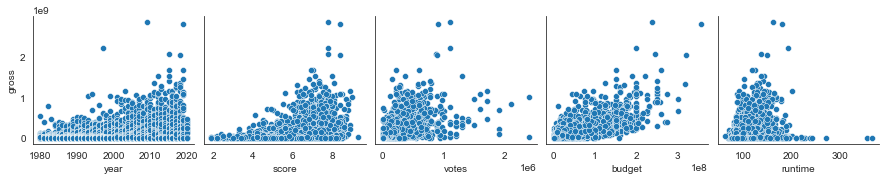

In [128]:
#...Association of the response with the predictors...#
sns.pairplot(movie_industry, y_vars=['gross'], x_vars=continuous)

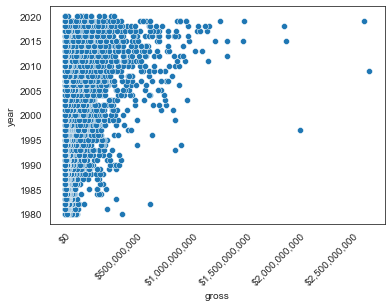

In [171]:
g = sns.scatterplot(x = 'gross', y = 'year', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

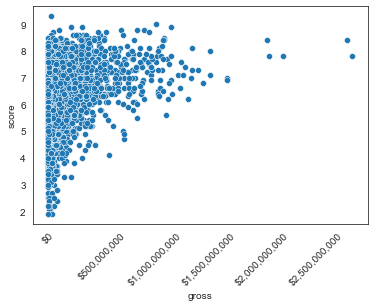

In [172]:
g = sns.scatterplot(x = 'gross', y = 'score', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

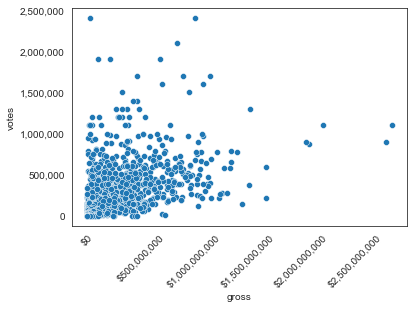

In [174]:
g = sns.scatterplot(x = 'gross', y = 'votes', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.yaxis.set_major_formatter('{x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

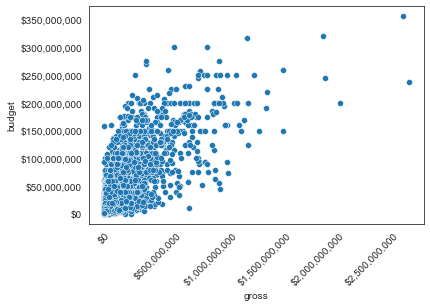

In [175]:
g = sns.scatterplot(x = 'gross', y = 'budget', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.yaxis.set_major_formatter('${x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

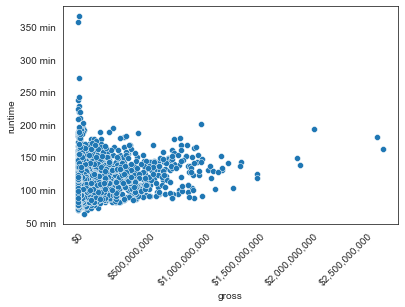

In [177]:
g = sns.scatterplot(x = 'gross', y = 'runtime', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.yaxis.set_major_formatter('{x:,.0f} min')
g.tick_params(axis='x', labelrotation=45)

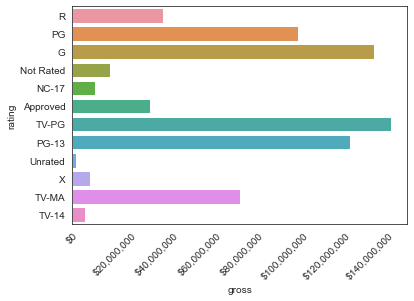

In [166]:
g = sns.barplot(x = 'gross', y = 'rating', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

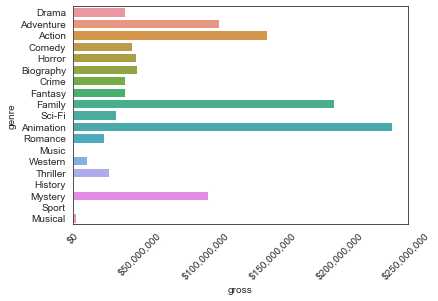

In [167]:
g = sns.barplot(x = 'gross', y = 'genre', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

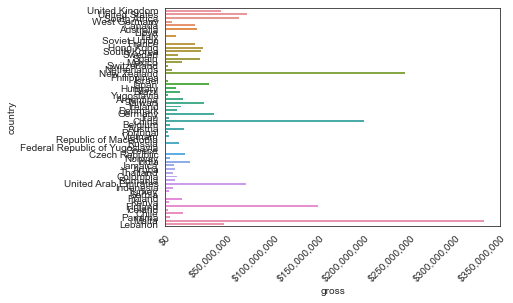

In [170]:
g = sns.barplot(x = 'gross', y = 'country', data = movie_industry, ci = None)
g.xaxis.set_major_formatter('${x:,.0f}')
g.tick_params(axis='x', labelrotation=45)

### Data cleaning
*By Lilly Sorkin*

From the data quality check we realized that:
1. After spending several hours working on it, we discovered that our initial dataset was too dificult to clean. It contained a multitude of listed dictionaries that we were unable to extract information from. As such we turned to our da

2. Some of the columns that we were expecting to be highly important were missing values. For example `budget` was missing 2171 values. Since imputing these values would not provide helpful information for our model, we removed all rows with missing values, leaving us with 5421 data points for our model development.

The code below implements the above cleaning.

In [137]:
movie_industry = pd.read_csv('movies.csv')

In [7]:
movie_industry.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [8]:
movie_industry.isnull().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

In [119]:
movie_industry_clean = movie_industry.dropna()
movie_industry_clean.reset_index(inplace=True)

In [5]:
movie_industry_clean.to_csv('movie_industry_clean.csv')

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [3]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [ ]:
######-----------Shuffling the dataset for K-fold------------#########

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [ ]:
We first wanted to visualize the 

In [ ]:

ols_object = smf.ols(formula = 'gross~budget+genre+rating+votes+continent+runtime+score+year', data = train)
model = ols_object.fit()
model.summary()

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.